In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import urllib.parse
import pandas as pd

In [ ]:
import random

In [ ]:
def search_pubmed(drug_name):
    """Функция для поиска публикаций о побочных эффектах лекарств в PubMed."""

    # Базовый URL API PubMed для поиска статей
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # Кодируем название препарата для безопасной передачи в URL
    encoded_drug_name = urllib.parse.quote(drug_name)

    # Параметры запроса к PubMed API
    params = {
        "db": "pubmed",  # Ищем в базе данных PubMed
        "term": f"{encoded_drug_name} AND (adverse effects[MeSH Terms] OR side effects[Title/Abstract] OR побочные эффекты[Title/Abstract])",  # Условия поиска: название препарата + термины о побочных эффектах
        "retmax": 100,  # Максимальное количество возвращаемых результатов
        "format": "json"  # Формат ответа - JSON
    }

    try:
        # Отправляем GET-запрос к PubMed API
        response = requests.get(base_url, params=params)
        # Проверяем, не вернул ли сервер ошибку HTTP
        response.raise_for_status()

        # Парсим ответ в формате JSON
        data = response.json()

        # Проверяем наличие результатов в ответе
        if "esearchresult" in data and "idlist" in data["esearchresult"]:
            # Возвращаем список ID найденных публикаций
            return data["esearchresult"]["idlist"]
        else:
            print(f"No results found for {drug_name}")
            return []  # Возвращаем пустой список, если результатов нет

    except requests.exceptions.HTTPError as e:
        # Обработка ошибки "Too Many Requests" (429)
        if e.response.status_code == 429:
            print("Too many requests. Waiting and retrying...")
            time.sleep(2)  # Ждем 10 секунд перед повторной попыткой
            return search_pubmed(drug_name)  # Рекурсивный вызов функции
        else:
            print(f"HTTP Error: {e}")  # Другие HTTP ошибки
            return []

    except requests.exceptions.RequestException as e:
        # Обработка общих ошибок запроса
        print(f"Request Exception: {e}")
        return []

In [ ]:
def get_article_details(pmid):
    """
    Получает заголовок и аннотацию статьи из PubMed по её ID.

    Args:
        pmid (str): PubMed ID статьи (например '12345678')

    Returns:
        tuple: (заголовок, аннотация) или ("N/A", "N/A") при ошибке
    """

    # Базовый URL API PubMed для получения полных данных статей
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

    # Параметры запроса:
    params = {
        "db": "pubmed",      # База данных PubMed
        "id": pmid,          # ID статьи для поиска
        "retmode": "xml"     # Формат ответа - XML
    }

    try:
        # Отправляем GET-запрос к PubMed API
        response = requests.get(base_url, params=params)
        # Проверяем статус ответа (вызовет исключение при ошибке HTTP)
        response.raise_for_status()

        # Парсим XML-ответ с помощью BeautifulSoup
        soup = BeautifulSoup(response.content, "xml")

        # Извлекаем заголовок статьи (с проверкой наличия тега)
        title = soup.find("ArticleTitle").text if soup.find("ArticleTitle") else "N/A"

        # Извлекаем аннотацию статьи (с проверкой наличия тега)
        abstract = soup.find("AbstractText").text if soup.find("AbstractText") else "N/A"

        return title, abstract  # Возвращаем найденные данные

    except requests.exceptions.RequestException as e:
        # Обработка всех возможных ошибок запроса:
        print(f"Request Exception: {e}")
        return "N/A", "N/A"  # Возвращаем значения по умолчанию при ошибке

In [ ]:
def parse_drug_side_effects(drug_list):
    """
    Основная функция для сбора информации о побочных эффектах препаратов из PubMed.
    Обрабатывает список препаратов, для каждого находит публикации и извлекает данные.

    Args:
        drug_list (list): Список названий препаратов для анализа

    Returns:
        list: Список словарей с собранными данными по каждому препарату
    """

    # Инициализируем список для хранения результатов
    results = []

    # Перебираем каждый препарат в списке
    for drug in drug_list:
        # Выводим информационное сообщение о текущем препарате
        print(f"Searching for {drug}...")

        # 1. Поиск публикаций по препарату в PubMed
        pmids = search_pubmed(drug)  # Получаем список ID публикаций

        # Если найдены публикации
        if pmids:
            # Перебираем все найденные ID публикаций
            for pmid in pmids:
                # 2. Получаем детальную информацию по каждой публикации
                title, abstract = get_article_details(pmid)

                # Формируем структуру данных и добавляем в результаты
                results.append({
                    "drug": drug,     # Название препарата
                    "pmid": pmid,     # ID публикации в PubMed
                    "title": title,  # Заголовок статьи
                    "abstract": abstract  # Аннотация статьи
                })

        # 3. Задержка между запросами для соблюдения лимитов API
        # Случайная задержка от 1 до 10 секунд для имитации "человеческого" поведения
        time.sleep(random.uniform(1,10))

    # Возвращаем собранные результаты
    return results

In [ ]:
# Список препаратов, которые будем искать.
drug_list = [
    "Aspirin"]

In [ ]:
results = parse_drug_side_effects(drug_list)

Searching for Aspirin...


In [ ]:
# Открываем файл для записи результатов в формате CSV
with open("drug_side_effects1.csv",          # Имя файла для сохранения
          "w",                             # Режим записи (write)
          newline="",                      # Пустые строки для корректной записи в CSV
          encoding="utf-8") as csvfile:     # Кодировка для поддержки Unicode
    """
    Параметры файла:
    - "w" - файл будет перезаписан, если существует
    - newline="" - предотвращает добавление лишних пустых строк
    - encoding="utf-8" - поддерживает кириллицу и спецсимволы
    """

    # Определяем названия столбцов для CSV файла
    fieldnames = ["drug",    # Название препарата
                 "pmid",    # ID публикации в PubMed
                 "title",   # Заголовок статьи
                 "abstract" # Текст аннотации
                ]

    # Создаем объект для записи словарей в CSV
    writer = csv.DictWriter(csvfile,         # Файловый объект
                          fieldnames=fieldnames)  # Заголовки столбцов

    # Записываем заголовок (первую строку с названиями столбцов)
    writer.writeheader()

    # Записываем все результаты построчно
    for result in results:
        """
        Каждый result - это словарь с ключами:
        - drug
        - pmid
        - title
        - abstract
        Ключи соответствуют fieldnames
        """
        writer.writerow(result)  # Запись одной строки данных

print("Результаты сохранены как drug_side_effects1.csv")

Результаты сохранены как drug_side_effects1.csv


In [ ]:
df = pd.read_csv('drug_side_effects.csv')

In [ ]:
df

,drug,pmid,title,abstract
0,Aspirin,40620204,The Nationwide Impact of Guidelines for Prophy...,Preeclampsia is a common pregnancy complicatio...
1,Aspirin,40514548,Repurposing salicylic acid as a versatile indu...,Chemically induced proximity (CIP) has remarka...
2,Aspirin,40503186,Eflornithine for the Chemoprevention of Lumina...,Gastrointestinal (GI) tract malignancies repre...
3,Aspirin,40463360,Study protocol for a randomized double-blinded...,Chronic rhinosinusitis with nasal polyps (CRSw...
4,Aspirin,40329926,Chronic Mountain Sickness: A Comprehensive Rev...,Chronic mountain sickness (CMS) is an acquired...
...,...,...,...,...
95,Aspirin,34366403,Concerning the unexpected prothrombotic state ...,"Currently, the world is coping with the COVID-..."
96,Aspirin,34348657,Perimyocarditis following first dose of the mR...,Half of U.S. adults have received at least one...
97,Aspirin,34290607,Genetic Variants in PTGS1 and NOS3 Genes Incre...,Objective: To assess the association between P...
98,Aspirin,34214300,A study of anticoagulant therapy in patients w...,One of the methods used to treat coronary arte...


In [ ]:
df.dropna()

,drug,pmid,title,abstract
0,Aspirin,40620204,The Nationwide Impact of Guidelines for Prophy...,Preeclampsia is a common pregnancy complicatio...
1,Aspirin,40514548,Repurposing salicylic acid as a versatile indu...,Chemically induced proximity (CIP) has remarka...
2,Aspirin,40503186,Eflornithine for the Chemoprevention of Lumina...,Gastrointestinal (GI) tract malignancies repre...
3,Aspirin,40463360,Study protocol for a randomized double-blinded...,Chronic rhinosinusitis with nasal polyps (CRSw...
4,Aspirin,40329926,Chronic Mountain Sickness: A Comprehensive Rev...,Chronic mountain sickness (CMS) is an acquired...
...,...,...,...,...
95,Aspirin,34366403,Concerning the unexpected prothrombotic state ...,"Currently, the world is coping with the COVID-..."
96,Aspirin,34348657,Perimyocarditis following first dose of the mR...,Half of U.S. adults have received at least one...
97,Aspirin,34290607,Genetic Variants in PTGS1 and NOS3 Genes Incre...,Objective: To assess the association between P...
98,Aspirin,34214300,A study of anticoagulant therapy in patients w...,One of the methods used to treat coronary arte...


In [ ]:
df['abstract'][99]

'Antiplatelet medications are the mainstay for secondary stroke treatment. Aspirin, clopidogrel, and aspirin-dipyridamole are commonly used antiplatelet medications. Other antiplatelet medications such as ticagrelor and prasugrel have been majorly used in cardiovascular or neuro-interventional specialties. Recent studies have paved a way to their use in secondary stroke prevention. In this review, we have briefly discussed the pharmacology of ticagrelor, published literature in cardiology and stroke trials, use of ticagrelor among patients with ischemic strokes, and compared its efficacy, limitations and side-effects with other antiplatelet medications.'

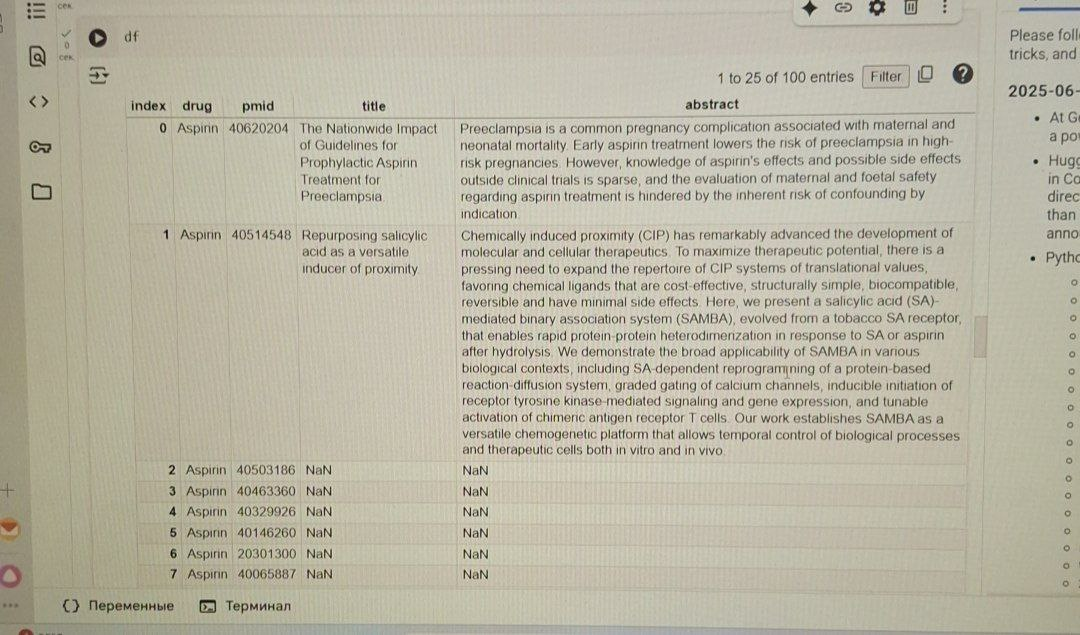

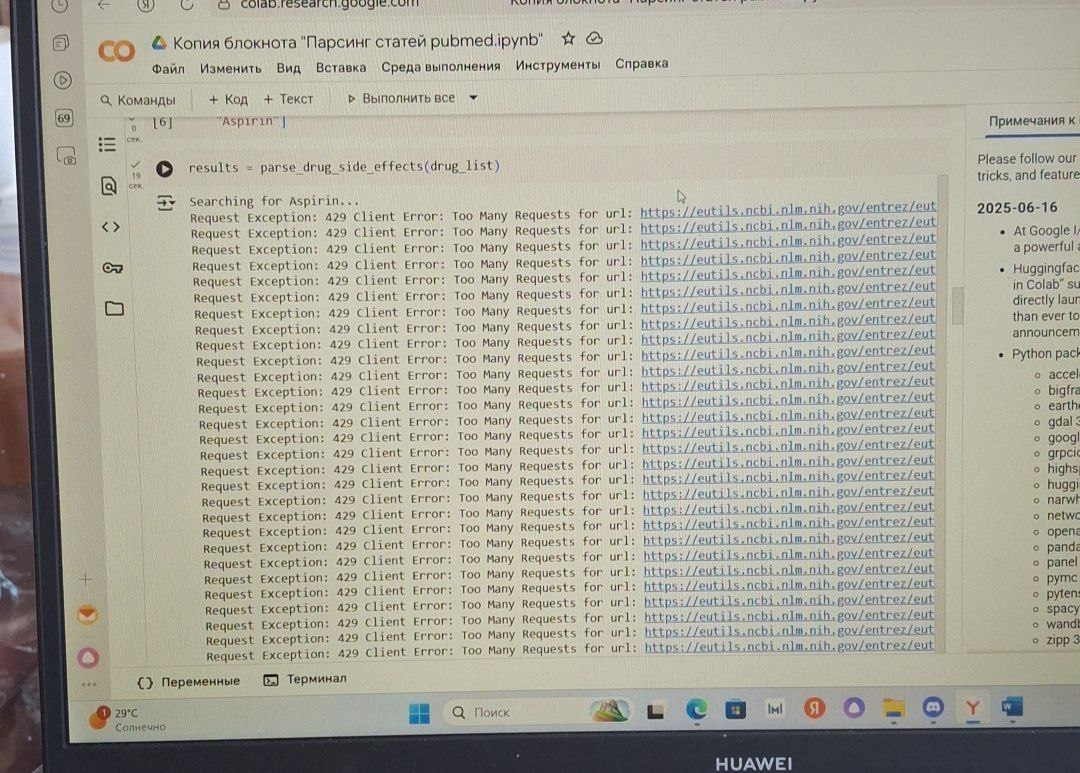